# Sahana Thoravalli Prabhuswamy

# Deep Learning Assignment - 13

# Github link

https://github.com/SahanaTP/DeepLearningAssignments

# Installing required libraries

**Gymnsium provides rich python libraries for Reinforcement Learning. It has pre-built environment and provides a means for the agent, learning algorithm and the environment to communicate.**

In [ ]:
!pip install swig

  Using cached swig-4.2.1-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.9 MB)


In [ ]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 14.9 MB/s eta 0:00:00


**Box 2d enviroment has 3 RL game environments and one of them is lunar lander**

In [ ]:
!pip install gymnasium[box2d]

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376101 sha256=d4f1e9ec850755896c1209b01f0329f9933b509b77ab782fcc27bc2ecc5d993b
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [ ]:
! pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.9 MB/s eta 0:00:00


**The basic components of RL are:**


1. Agent - Autonomous decision making entity which interacts with the environment to achieve a goal
2. Environment - external entity or context that interacts with agents with rewards or punishments
3. State - Different stages an agent can go to
4. Reward - extra points earned by the agent by taking the right steps
5. terminal - final state

The lunar lander environment facilitates the agent to make 4 descrete actions:

1. do nothing
2. fire left orientation engine
3. fire main engine
4. fire right orientation engine


* Q - learning is an off-policy, model free, value based algorithm that will predict best series of actions based on the current state of the agent.

* Q refers to the quality of the reward abtained for the given state and action.

* Here a neural network is used as a function approximator i.e. two deep neural networks(Agent and DoubleQAgent) one to predict the actions and other to predict/learn the Q values.

* In the following code a memory buffer is used to store the state, action, reward, new_state and terminal state and to provide a batch of random samples of there parameters.

* This second neural network has the same shape and architecture as the one used for the action-selection and is periodically updated with the weights of the action-selection network.

* Parameters used for training both the DQNs:

gamma=0.99, epsilon=1.0, batch_size=128, lr=0.001,
epsilon_dec=0.996, epsilon_end=0.01, mem_size=1000000

alpha  = learning rate (α) used by the DQN implementation

gamma = discount factor (γ) of future rewards, A smaller gamma value of 0.9 will be faster but will prevent the agent from properly crediting success after 10 steps in the future (1/(1-γ) = 1/(1-0.9) = 10) while a large value like γ = 0.999 will allow the agent to look all the way to 1,000 actions in the future (1/(1-γ) = 1/(1-0.999) = 1000) but will be slow to converge or learn. Hence, an in between value of 0.99 is chosen to consider 100 steps in the future.

epsilon = the decay rate of ε (ε-decay) to establish proper exploitation versus exploration balance.

epsilon_dec = decrement of epsilon for larger spaces, a decay rate of 0.996 will initially give importance to more exploration and in later stages gives more importance to exploitation

* The next Q value is updated using the formula:
q_updated = rewards + gamma * q_next * (1 - terminals)


* An episode is considered a solution if it scores at least 200 points. Different points are assigned for different actions and a -100/ 100 pointis received for crashing or reaching the goal

* Both exploitation and exploration features are used to reach the goal(200 points)



In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import collections # For dequeue for the memory buffer
import random
import dill as pickle # For storing the buffer state

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class MemoryBuffer(object):
    def __init__(self, max_size):
        self.memory_size = max_size
        self.trans_counter=0 # num of transitions in the memory
                             # this count is required to delay learning
                             # until the buffer is sensibly full
        self.index=0         # current pointer in the buffer
        self.buffer = collections.deque(maxlen=self.memory_size)
        self.transition = collections.namedtuple("Transition", field_names=["state", "action", "reward", "new_state", "terminal"])


    def save(self, state, action, reward, new_state, terminal):
        t = self.transition(state, action, reward, new_state, terminal)
        self.buffer.append(t)
        self.trans_counter = (self.trans_counter + 1) % self.memory_size

    def random_sample(self, batch_size):
        assert len(self.buffer) >= batch_size # should begin sampling only when sufficiently full
        transitions = random.sample(self.buffer, k=batch_size) # number of transitions to sample
        states = torch.from_numpy(np.vstack([e.state for e in transitions if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in transitions if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in transitions if e is not None])).float().to(device)
        new_states = torch.from_numpy(np.vstack([e.new_state for e in transitions if e is not None])).float().to(device)
        terminals = torch.from_numpy(np.vstack([e.terminal for e in transitions if e is not None]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, new_states, terminals

class QNN(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

class Agent(object):
    def __init__(self, gamma=0.99, epsilon=1.0, batch_size=128, lr=0.001,
                 epsilon_dec=0.996,  epsilon_end=0.01,
                 mem_size=1000000):
        self.gamma = gamma # alpha = learn rate, gamma = discount
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec # decrement of epsilon for larger spaces
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.memory = MemoryBuffer(mem_size)

    def save(self, state, action, reward, new_state, done):
        # self.memory.trans_counter += 1
        self.memory.save(state, action, reward, new_state, done)

    def choose_action(self, state):
        # state = state[np.newaxis, :]
        rand = np.random.random()
        state = torch.from_numpy(state).float().unsqueeze(0)
        self.q_func.eval()
        with torch.no_grad():
            action_values = self.q_func(state)
        self.q_func.train()
        # print(state)
        if rand > self.epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            # exploring: return a random action
            return np.random.choice([i for i in range(4)])

    def reduce_epsilon(self):
        self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > \
                       self.epsilon_min else self.epsilon_min

    def learn(self):
        raise Exception("Not implemented")

    def save_model(self, path):
        torch.save(self.q_func.state_dict(), path)

    def load_saved_model(self, path):
        self.q_func = QNN(8, 4, 42).to(device)
        self.q_func.load_state_dict(torch.load(path))
        self.q_func.eval()


class DoubleQAgent(Agent):
    def __init__(self, gamma=0.99, epsilon=1.0, batch_size=128, lr=0.001,
                 epsilon_dec=0.996,  epsilon_end=0.01,
                 mem_size=1000000, replace_q_target = 100):

        super().__init__(lr=lr, gamma=gamma, epsilon=epsilon, batch_size=batch_size,
             epsilon_dec=epsilon_dec,  epsilon_end=epsilon_end,
             mem_size=mem_size)

        self.replace_q_target = replace_q_target
        self.q_func = QNN(8, 4, 42).to(device)
        self.q_func_target = QNN(8, 4, 42).to(device)
        self.optimizer = optim.Adam(self.q_func.parameters(), lr=lr)


    def learn(self):
        if self.memory.trans_counter < self.batch_size: # wait before you start learning
            return

        # 1. Choose a sample from past transitions:
        states, actions, rewards, new_states, terminals = self.memory.random_sample(self.batch_size)

        # 2. Update the target values
        q_next = self.q_func_target(new_states).detach().max(1)[0].unsqueeze(1)
        q_updated = rewards + self.gamma * q_next * (1 - terminals)
        q = self.q_func(states).gather(1, actions)

        # 3. Update the main NN
        loss = F.mse_loss(q, q_updated)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 4. Update the target NN (every N-th step)
        if self.memory.trans_counter % self.replace_q_target == 0: # wait before you start learning
            for target_param, local_param in zip(self.q_func_target.parameters(), self.q_func.parameters()):
                target_param.data.copy_(local_param.data)

        # 5. Reduce the exploration rate
        self.reduce_epsilon()



    def save_model(self, path):
        super().save_model(path)
        torch.save(self.q_func.state_dict(), path+'.target')


    def load_saved_model(self, path):
        super().load_saved_model(path)
        self.q_func_target = QNN(8, 4, 42).to(device)
        self.q_func_target.load_state_dict(torch.load(path+'.target'))
        self.q_func_target.eval()



In [ ]:
import gymnasium as gym
import os
import matplotlib.pyplot as plt
import json # for dumping debug data
import time # for benchmarking
import numpy as np

LEARN_EVERY = 4
def train_agent(n_episodes=2000, load_latest_model=False):
    print("Training a DDQN agent on {} episodes. Pretrained model = {}".format(n_episodes,load_latest_model))
    env = gym.make("LunarLander-v2")
    agent = DoubleQAgent(gamma=0.99, epsilon=1.0, epsilon_dec=0.995, lr=0.001, mem_size=200000, batch_size=128, epsilon_end=0.01)
    if load_latest_model:
        agent.load_saved_model('ddqn_torch_model.h5')
        print('Loaded most recent: ddqn_torch_model.h5')

    scores = []
    eps_history = []
    start = time.time()
    for i in range(n_episodes):
        terminated = False
        truncated = False
        score = 0
        state = env.reset()[0]
        steps = 0
        while not (terminated or truncated):
            action = agent.choose_action(state)
            new_state, reward, terminated, truncated, info = env.step(action)
            agent.save(state, action, reward, new_state, terminated)
            state = new_state
            if steps > 0 and steps % LEARN_EVERY == 0:
                agent.learn()
            steps += 1
            score += reward

        eps_history.append(agent.epsilon)
        scores.append(score)
        avg_score = np.mean(scores[max(0, i-100):(i+1)])

        if (i+1) % 10 == 0 and i > 0:
            # Report expected time to finish the training
            print('Episode {} in {:.2f} min. Expected total time for {} episodes: {:.0f} min. [{:.2f}/{:.2f}]'.format((i+1),
                                                                                                                      (time.time() - start)/60,
                                                                                                                      n_episodes,
                                                                                                                      (((time.time() - start)/i)*n_episodes)/60,
                                                                                                                      score,
                                                                                                                      avg_score))

        if (i+1) % 100 == 0 and i > 0:
            # Save the model every N-th step just in case
            agent.save_model('ddqn_torch_model.h5')
            with open("ddqn_torch_dqn_scores_{}.json".format(int(time.time())), "w") as fp:
                json.dump(scores, fp)
            with open("ddqn_torch_eps_history_{}.json".format(int(time.time())), "w") as fp:
                json.dump(eps_history, fp)

    return agent

In [ ]:
# Uncomment to train
agent = train_agent(n_episodes=1500, load_latest_model=False)

Training a DDQN agent on 1500 episodes. Pretrained model = False
Episode 10 in 0.03 min. Expected total time for 1500 episodes: 4 min. [-101.19/-208.35]
Episode 20 in 0.07 min. Expected total time for 1500 episodes: 6 min. [-58.09/-166.79]
Episode 30 in 0.15 min. Expected total time for 1500 episodes: 8 min. [-52.83/-174.55]
Episode 40 in 0.31 min. Expected total time for 1500 episodes: 12 min. [-252.44/-167.49]
Episode 50 in 0.45 min. Expected total time for 1500 episodes: 14 min. [-148.08/-153.60]
Episode 60 in 0.55 min. Expected total time for 1500 episodes: 14 min. [-107.01/-149.11]
Episode 70 in 0.70 min. Expected total time for 1500 episodes: 15 min. [-85.65/-144.03]
Episode 80 in 0.93 min. Expected total time for 1500 episodes: 18 min. [-72.27/-138.18]
Episode 90 in 1.20 min. Expected total time for 1500 episodes: 20 min. [-7.90/-128.91]
Episode 100 in 1.57 min. Expected total time for 1500 episodes: 24 min. [-37.35/-119.70]
Episode 110 in 1.84 min. Expected total time for 1500 

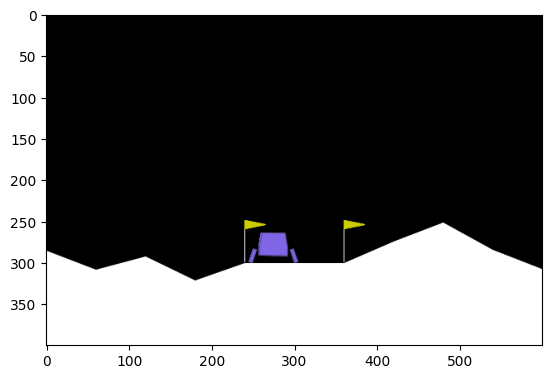

In [ ]:
# Visualize the model
import gymnasium as gym
import os
import matplotlib.pyplot as plt
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

# Set path to the model to visualize
model_to_animate = '/content/ddqn_torch_model.h5'

def animate_model(name, atype='single'):
    env = gym.make("LunarLander-v2", render_mode="rgb_array")
    agent = DoubleQAgent(gamma=0.99, epsilon=0.0, lr=0.0005, mem_size=200000, batch_size=64, epsilon_end=0.01)
    agent.load_saved_model(name)
    state, info = env.reset(seed=12)
    for _ in range(5):
        terminated = False
        truncated = False
        while not (terminated or truncated):
            action = agent.choose_action(state)
            new_state, reward, terminated, truncated, info = env.step(action)
            state = new_state
            clear_output(wait=True)
            plt.imshow( env.render() )
            plt.show()
        state = env.reset()[0]
    env.close()
animate_model(model_to_animate, atype='double')

# Results

* An Episode is a single run from initial state to final state. The model or agent was trained on 1500 episode.

* The goal is said to be achieved when 200 points is reached. At 310 episode the 200 points was reached and first time goal was reached.

* 5 episodes are replayed after the model is saved and used to run the experiment and in 4 episodes the satellite landed on the right spot.

* So there is a 80% success rate for the trained model to land on the right spot

* The implemented solution relies on three particular hyperparameters that had to be carefully selected to achieve successful results: the learning rate (α) used by the DNN implementation, the discount factor (γ = 0.99) of future rewards, and the decay rate of ε (ε-decay) to establish proper exploitation versus exploration balance.